### Back transform a PSF into a pupil

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import numpy as np
import PIL
from math import hypot
import scipy.ndimage
import scipy as sp
from FT_model import model_FT
from numpy.fft import fft2
from numpy.fft import ifft2
from numpy.fft import fftshift
from numpy.fft import ifftshift
from numpy.random import randint
import warnings
warnings.filterwarnings('ignore')

image_path = "Images/"

### Notes: 
- Currently coherent PSF's are only formed in the case where the power across the aperture is not a flat field
    - Power = np.abs(pupil)
    - Power distrubuted in an airy disk manner seems to maintain the coherence
- Similarly the method for 'zeroing' the regions beyond some radius only affects the power and not the phase across the whole array
    - Need to implement zeroing step in the conversion of the image to a complex array

> These concepts were discovered and explored in the non binary version of this notebook

> **Develop these two scrips in tandem!!**

In [3]:
def input_image(image_path):
    img = PIL.Image.open(image_path)
    im_array = np.array(img)
    return im_array

def im_to_greyscale(im_array):
    greyscale_array = np.zeros(im_array.shape[:2])
    c = greyscale_array.shape[0]//2

    for i in range(len(im_array)):
        for j in range(len(im_array[0])):
            y = i - c
            x = j - c
            r = int(hypot(x, y))

            if r < 12:
                greyscale_array[i][j] = 0
            elif r < 16:
                if x > 0 or y < 0:
                    greyscale_array[i][j] = 0

            elif np.sum(im_array[i][j].tolist()) > 600:
                greyscale_array[i][j] = 0
            else:
                greyscale_array[i][j] = 1
    
    return greyscale_array

def smooth_gaussian(array, sigma_x, sigma_y):
    sigma = [sigma_x, sigma_y]
    smoothed_array = sp.ndimage.filters.gaussian_filter(array, sigma, mode='constant')
    return smoothed_array

def gaussian(x, y, p, mu, sig):
    a = 1 / (sig * np.sqrt(2 * np.pi)) 
    b = ((x-mu)**2)/(2*sig**2)
    c = ((y-mu)**2)/(2*sig**2)
    g_out = a*np.exp(-(b+c)**p)
    return g_out

def get_max_gauss(r, mu):
    gauss_vals = []
    for k in range(-r,r+1):
        for l in range(-r,r+1):
            x = k
            y = l
            if hypot(x, y) <= r:
                gauss_vals.append(gaussian(x, y, 1, 0, mu))
    max_gauss = max(gauss_vals)
    return max_gauss

def is_central(array, i, j):
    central = True
    for k in range(-1,2):
        for l in range(-1,2):
            if array[i+k][j+l] > array[i][j]: 
                central = False
    return central

def get_value(rand=False):
    if rand:
        return randint(2)*2 - 1 # return +1, -1
    else:
        i = 0
        while True:
            yield (i%2)*2 - 1
            i += 1

def find_centroids(array, zero_threshold=0.1):
    comp_array = np.zeros(array.shape, dtype=np.complex)
    gridsize = array.shape[0]
    centroids = []
    value_generator = get_value()

    for i in range(gridsize):
        for j in range(gridsize):
            if array[i][j] < zero_threshold:
                comp_array[i][j] = np.complex(0,0)
                
            elif is_central(array, i, j): # is this a max pixel
                val = next(value_generator)
                comp_array[i][j] = np.complex(val, 0)
                centroids.append((i, j))
                
            else:
                comp_array[i][j] = np.complex(0, 0) # default
                
    return centroids, comp_array

def assign_radial_values(centroids, comp_array, r=10, mu=8):
    gridsize = comp_array.shape[0]
    max_gauss = get_max_gauss(r, mu)
    index = 0
    for i in range(gridsize):
        for j in range(gridsize):
            if i == centroids[index][0] and j == centroids[index][1]:
                if index < len(centroids)-1:
                    index += 1

                for k in range(-r,r+1):
                    for l in range(-r,r+1):
                        x = k
                        y = l
                        if hypot(x, y) <= r:
                            # Values input to gaussian can be tweaked
                            comp_array[i+k][j+l] = gaussian(x, y, 1, 0, mu)*comp_array[i][j]/max_gauss
    return comp_array

def set_max_radius(comp_array, r_max):
    gridsize = comp_array.shape[0]
    c = gridsize//2
    wf = np.zeros(comp_array.shape, dtype=np.complex)

    for i in range(gridsize):
        for j in range(gridsize):
            x = i-c 
            y = j-c
            r = hypot(x, y)
            if r > r_max:
                wf[i][j] = np.complex(0,0)
            else:
                wf[i][j] = comp_array[i][j]
    return wf

def binarise(wf, aperture, r_max):
    gridsize = np.shape(wf)[0]
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)
    
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            r = sampling*hypot(x,y)
            if r > r_max:
                wfarr[i][j] = v
            else:
                wfarr[i][j] = black if np.abs(np.angle(wf[i][j])) > np.pi/2 else white
    
    return wfarr

def binarise_pix(wf, threshold, r_max):
    gridsize = np.shape(wf)[0]
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    
    white = np.complex(1,0)
    black = np.complex(-1,0)
    v = np.complex(0,0)
    
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            r = hypot(x,y)
            if r > r_max:
                wfarr[i][j] = v
            else:
                if np.angle(wf[i][j]) > np.pi*threshold:
                    wfarr[i][j] = black  
                else:
                    wfarr[i][j] = white
    
    return wfarr

- Input image and covnert to an array
- Convert image array to greyscale array
- Smooth the array by applying gaussian smoothing

In [4]:
im_array = input_image("ideal_psf.jpg")
bool_array = im_to_greyscale(im_array)
array = smooth_gaussian(bool_array, 3, 3)

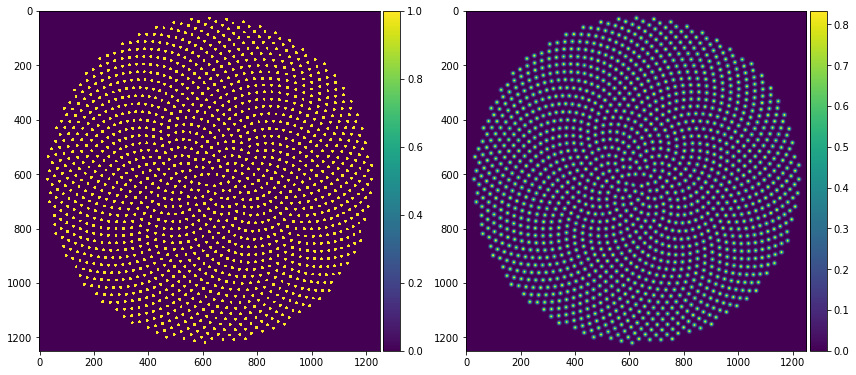

In [5]:
c = bool_array.shape[0]//2
size = 1250
fsize = 12

fig, ax = plt.subplots(1, 2, figsize=(fsize, fsize))
im0 = ax[0].imshow(np.abs(bool_array[c-size//2:c+size//2,c-size//2:c+size//2]))
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, ax=ax[0], cax=cax0)

im1 = ax[1].imshow(np.abs(array[c-size//2:c+size//2,c-size//2:c+size//2]))
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, ax=ax[1], cax=cax1)

fig.tight_layout()
plt.show()

- Use greyscale array to find the central points of the dots
- Create a complex array of alternating +'ve and -'ve phase values for each point

In [6]:
centroids, comp_array = find_centroids(array)
comp_array = assign_radial_values(centroids, comp_array)

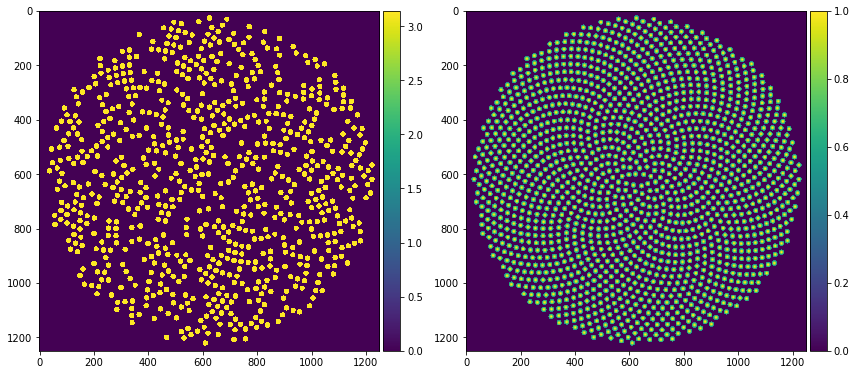

In [7]:
size = 1250

fsize = 12
c = comp_array.shape[0]//2
fig, ax = plt.subplots(1, 2, figsize=(fsize, fsize))

im0 = ax[0].imshow(np.angle(comp_array[c-size//2:c+size//2,c-size//2:c+size//2]))
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, ax=ax[0], cax=cax0)

im1 = ax[1].imshow(np.abs(comp_array[c-size//2:c+size//2,c-size//2:c+size//2]))
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, ax=ax[1], cax=cax1)

fig.tight_layout()
plt.show()

In [8]:
# comp_array_mod = modify_FT(comp_array, 10, 150, 10, False)

In [9]:
# plt.imshow(np.abs(comp_array_mod))
# plt.show()

- Reduce size of idealised PSF
- Inverse FT this to get a pupil

In [29]:
r_max = 150
# wf_initial = set_max_radius(comp_array, r_max)
# wf_initial = modify_FT(comp_array, 10, 150)
wf_initial = modify_FT_2(comp_array, 10, 150)
pupil = np.fft.fftshift(np.fft.ifft2(wf_initial))

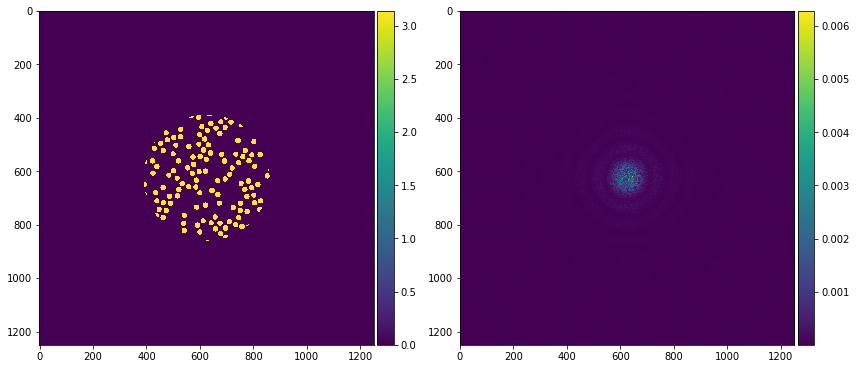

In [39]:
size = 1250

fsize = 12
c = pupil.shape[0]//2
fig, ax = plt.subplots(1, 2, figsize=(fsize, fsize))

# im0 = ax[0].imshow(np.abs(wf_initial[c-size//2:c+size//2,c-size//2:c+size//2]**2))
im0 = ax[0].imshow(np.angle(wf_initial[c-size//2:c+size//2,c-size//2:c+size//2]))
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, ax=ax[0], cax=cax0)

# im1 = ax[1].imshow(np.angle(pupil[c-size//2:c+size//2,c-size//2:c+size//2]))
im1 = ax[1].imshow(np.abs(pupil[c-size//2:c+size//2,c-size//2:c+size//2]))
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, ax=ax[1], cax=cax1)

fig.tight_layout()
plt.show()

- Binarise the phase values about some threshold and zero the amplitude outside the given raidus

In [25]:
def scale_phase_range(wf, r_max):
    gridsize = np.shape(wf)[0]
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    v = np.complex(0,0)
    
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            r = hypot(x,y)
            if r > r_max:
                wfarr[i][j] = v
            else:
                # Scalse the phase so the range goes from -pi - pi -> 0 - pi
                phase = np.pi/2 + np.angle(wf[i][j])*0.5
                mag = np.abs(wf[i][j])
                
                wfarr[i][j] = mag*np.exp(1j*phase)
    return wfarr

def fold_phase_range(wf, r_max):
    gridsize = np.shape(wf)[0]
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    v = np.complex(0,0)
    
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            r = hypot(x,y)
            if r > r_max:
                wfarr[i][j] = v
            else:
                # Scalse the phase so the range goes from -pi - pi -> 0 - pi
                phase = np.abs(np.angle(wf[i][j]))
                mag = np.abs(wf[i][j])
                
                wfarr[i][j] = mag*np.exp(1j*phase)
    return wfarr

def scale_phase(wf, ratio, r_max):
    gridsize = np.shape(wf)[0]
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    v = np.complex(0,0)
    
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            r = hypot(x,y)
            if r > r_max:
                wfarr[i][j] = v
            else:
                mag = np.abs(wf[i][j])
                if np.angle(wf[i][j]) >= np.pi/2:
                    # This simply shifts the phase around such that both sides are scaled the same amount
                    phase =  np.pi - ratio*(np.pi - np.angle(wf[i][j]))
                else:
                    phase = ratio*np.angle(wf[i][j])
                    
                wfarr[i][j] = mag*np.exp(1j*phase)
    return wfarr

def push_phase(wf, value):
    gridsize = np.shape(wf)[0]
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    v = np.complex(0,0)
    
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            r = hypot(x,y)
            if r > c:
                wfarr[i][j] = v
            else:
                mag = np.abs(wf[i][j])
                if np.angle(wf[i][j]) >= np.pi/2:
                    phase_pushed = np.angle(wf[i][j]) + value
                    phase = phase_pushed if phase_pushed <= np.pi else np.pi
                else:
                    phase_pushed = np.angle(wf[i][j]) - value
                    phase = phase_pushed if phase_pushed >= 0 else 0
                
                wfarr[i][j] = mag*np.exp(1j*phase)
    return wfarr

def modify_FT_double(PSF, p, sig1, sig2, thresh=1e-6):
    shape = np.shape(PSF)
    out = np.zeros(shape)
    mu = shape[0]//2
    for i in range(shape[0]):
        for j in range(shape[1]):
            Z = PSF[i][j]
            g1 = gaussian(i, j, p, mu, sig1)
            g2 = gaussian(i, j, p, mu, sig2)
            G = g1-g2
            if G < 0:
                G = 0
                
            phi = np.angle(Z)
            if np.abs(Z) < 0.1:
                mag = 0
            else:
                mag = G
            out[i][j] = mag*np.exp(1j*phi)

    return out

def modify_FT(PSF, p, sig, thresh=1e-6):
    shape = np.shape(PSF)
    out = np.zeros(shape, dtype=complex)
    mu = shape[0]//2
    for i in range(shape[0]):
        for j in range(shape[1]):
            Z = PSF[i][j]
            mag = gaussian(i, j, p, mu, sig)
    
            if mag < thresh:
                out[i][j] = np.complex(0,0)
            else:
                out[i][j] = mag*np.exp(1j*np.angle(Z))

    return out

def modify_FT_2(PSF, p, sig, thresh=1e-6):
    shape = np.shape(PSF)
    out = np.zeros(shape, dtype=complex)
    mu = shape[0]//2
    for i in range(shape[0]):
        for j in range(shape[1]):
            Z = PSF[i][j]
            mag = gaussian(i, j, p, mu, sig)
    
            if mag < thresh:
                out[i][j] = np.complex(0,0)
            else:
                out[i][j] = np.abs(Z)*np.exp(1j*np.angle(Z))

    return out


In [62]:
# p = 10
# sig1 = 150
# sig2 = 10
# max_val = 0

# shape = np.shape(PSF)
# out = np.zeros(shape)
# for i in range(1250):
#     for j in range(1250):
#         g1 = gaussian(i, j, p, 0, sig1)
#         g2 = gaussian(i, j, p, 0, sig2)
#         G = g1-g2
#         if G > max_val:
#             max_val = G
            
# print(max_val)

In [63]:
# plt.imshow(np.abs(fft2(pupil)))
# plt.colorbar()

In [121]:
threshold = 0.0
size = 400
# pupil_binary = binarise_pix(pupil, threshold)
# pupil_scaled = scale_phase(scale_phase_range(pupil), 0.9)
pupil_scaled = scale_phase_range(pupil, 1250//4)*1e3
# pupil_scaled = fold_phase_range(pupil, 1250//4)
# PSF = fft2(pupil_scaled)


new_pupil = scale_phase(pupil_scaled, 1e-6, 1250//4)
PSF = fft2(new_pupil)

new_pupil2 = binarise_pix(new_pupil, 0.5, 1250//4)
PSF2 = fft2(new_pupil2)

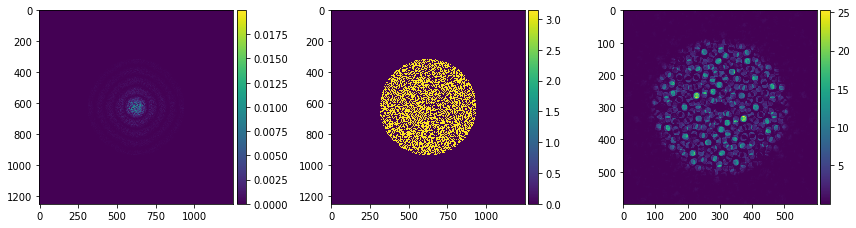

In [149]:
size = 600

fsize = 12
c = pupil.shape[0]//2
fig, ax = plt.subplots(1, 3, figsize=(fsize, fsize))

im0 = ax[0].imshow(np.abs(new_pupil))
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, ax=ax[0], cax=cax0)

im1 = ax[1].imshow(np.angle(new_pupil))
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, ax=ax[1], cax=cax1)

im2 = ax[2].imshow(np.abs(PSF[c-size//2:c+size//2,c-size//2:c+size//2]**2))
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, ax=ax[2], cax=cax2)

fig.tight_layout()
plt.show()

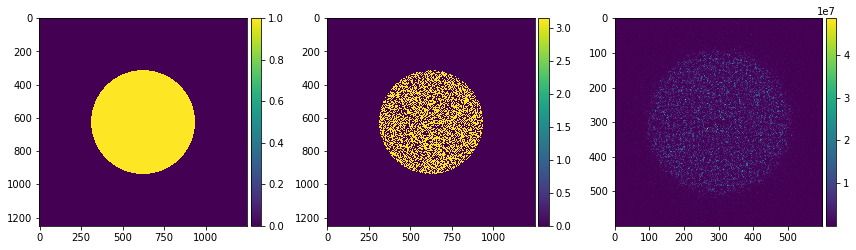

In [151]:
size = 600

fsize = 12
c = pupil.shape[0]//2
fig, ax = plt.subplots(1, 3, figsize=(fsize, fsize))

im0 = ax[0].imshow(np.abs(new_pupil2))
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, ax=ax[0], cax=cax0)

im1 = ax[1].imshow(np.angle(new_pupil2))
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, ax=ax[1], cax=cax1)

im2 = ax[2].imshow(np.abs(PSF2[c-size//2:c+size//2,c-size//2:c+size//2]**2))
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, ax=ax[2], cax=cax2)

fig.tight_layout()
plt.show()

In [145]:
bins = np.linspace(0, np.pi, num=50)
vals = np.zeros(50)
for i in range(1250):
    for j in range(1250):
        val = np.angle(new_pupil[i][j])
        x = i - c
        y = j - c
        r = hypot(x, y)
        if r >= 1250//4:
            continue
        for k in range(len(bins)-1):
            if val >= bins[k] and val < bins[k+1]:
                vals[k] += 1  

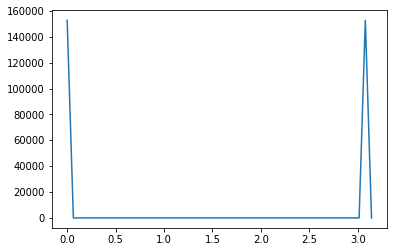

In [146]:
plt.plot(bins, vals)

In [162]:
A1 = np.zeros([1250, 1250])
A2 = np.zeros([1250, 1250])

for i in range(1250):
    for j in range(1250):
        A1[i][j] = np.angle(new_pupil[i][j])
        A2[i][j] = np.angle(new_pupil2[i][j])
        
A = A1 - A2

In [165]:
print(np.max(A))

1.5707894476463217e-06


> Variation in the angles of each pupil is ~ 1e-6 -> Inconsequential

> Further testing has shown that the different PSF are caused by variation in the input power across the pupil.
> Coherence in the PSF is maintained by having this airy disk like input

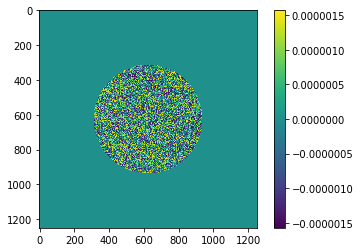

In [160]:
plt.imshow(A)
plt.colorbar()
plt.show()

In [17]:
from copy import deepcopy

p = 10
sig1 = 150
sig2 = 10

pupil_ranged = scale_phase_range(pupil)
pupil_inverse_scaled = deepcopy(pupil_ranged)
# pupil_inverse_pushed = deepcopy(pupil)

0

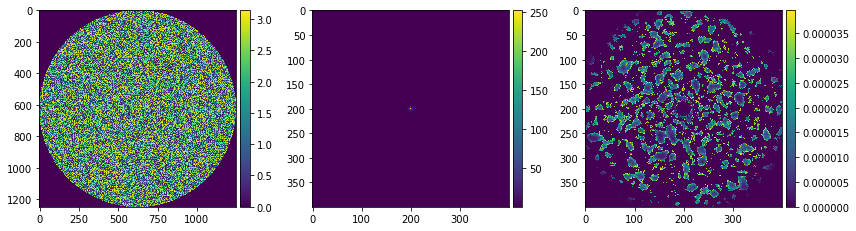

In [19]:
for i in range(1):
    print(i, end='')
    pupil_scaled = scale_phase(pupil_inverse_scaled, 0.8)
    PSF_scaled = fftshift(fft2(pupil_scaled))
    PSF_scaled_mod = modify_FT(PSF_scaled, p, sig1, sig2, mult=False)
#     pupil_inverse_scaled = ifft2(PSF_scaled_mod)



#     pupil_pushed = push_phase(pupil_inverse_pushed, 0.05)
#     PSF_pushed = fft2(pupil_pushed)
#     PSF_pushed_mod = modify_FT(PSF_pushed, p, sig1, sig2, mult=False)
#     pupil_inverse_pushed = fftshift(ifft2(PSF_pushed_mod))
    
    size = 400
    fsize = 12
    c = pupil.shape[0]//2
    fig, ax = plt.subplots(1, 3, figsize=(fsize, fsize))
#     fig, ax = plt.subplots(1, 2, figsize=(fsize, fsize))

    im0 = ax[0].imshow(np.abs(np.angle(pupil_scaled)))
    divider0 = make_axes_locatable(ax[0])
    cax0 = divider0.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im0, ax=ax[0], cax=cax0)


    im1 = ax[1].imshow(np.abs(PSF_scaled[c-size//2:c+size//2,c-size//2:c+size//2])**2)
    divider1 = make_axes_locatable(ax[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, ax=ax[1], cax=cax1)
    
    im2 = ax[2].imshow(np.abs(PSF_scaled_mod[c-size//2:c+size//2,c-size//2:c+size//2])**2)
    divider2 = make_axes_locatable(ax[2])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, ax=ax[2], cax=cax2)


#     im3 = ax[3].imshow(np.abs(np.angle(pupil_inverse_scaled)))
#     divider3 = make_axes_locatable(ax[3])
#     cax3 = divider3.append_axes("right", size="5%", pad=0.05)
#     fig.colorbar(im3, ax=ax[3], cax=cax3)

    fig.tight_layout()
    plt.show()

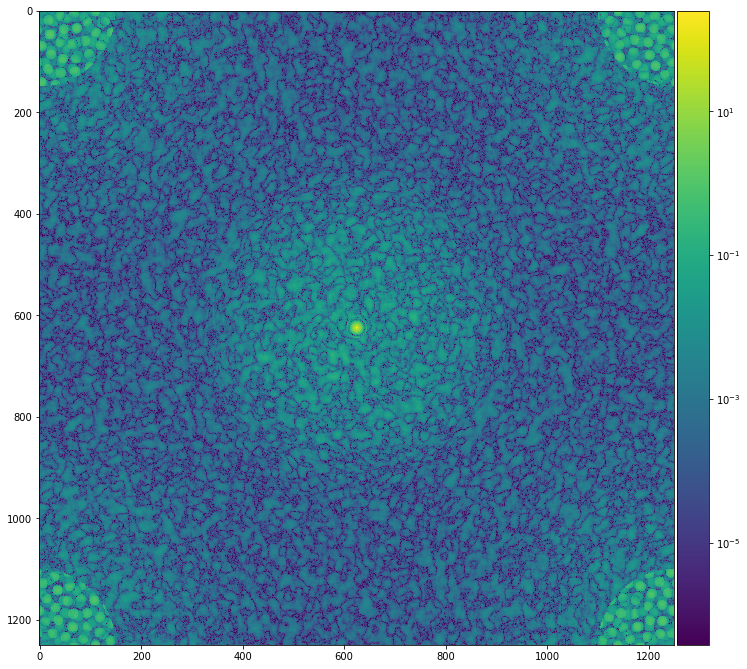

In [16]:
# print(PSF_scaled)
size = 1250
fig, ax = plt.subplots(1, 1, figsize=(fsize, fsize))
im1 = ax.imshow(np.abs(PSF_scaled[c-size//2:c+size//2,c-size//2:c+size//2])**2, norm=colors.LogNorm())
# im1 = ax.imshow(np.angle(PSF_scaled[c-size//2:c+size//2,c-size//2:c+size//2]))
divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, ax=ax, cax=cax1)

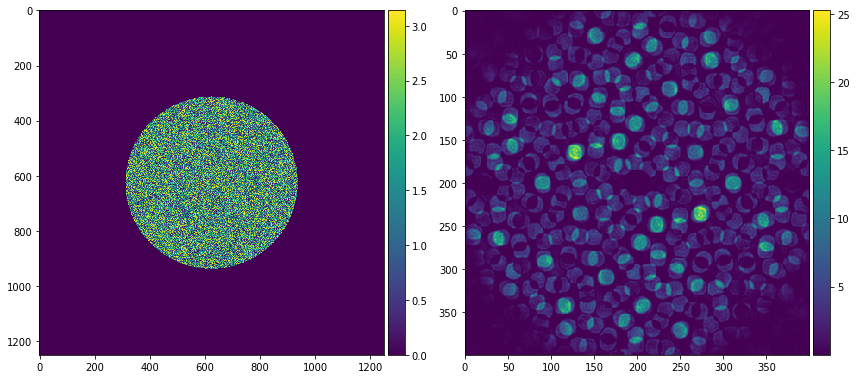

In [168]:
size = 400

fsize = 12
c = PSF.shape[0]//2
fig, ax = plt.subplots(1, 2, figsize=(fsize, fsize))

# im0 = ax[0].imshow(np.abs(np.angle(pupil_binary)))
im0 = ax[0].imshow(np.abs(np.angle(pupil_scaled)))
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, ax=ax[0], cax=cax0)


im1 = ax[1].imshow(np.abs(PSF[c-size//2:c+size//2,c-size//2:c+size//2])**2)
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, ax=ax[1], cax=cax1)

fig.tight_layout()
plt.show()